In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import random
from copy import deepcopy

from abc import ABC, abstractmethod
from numba import jit
from numba.experimental import jitclass

In [3]:
from importlib import reload
import logging

reload(logging)
logging.basicConfig(format='[%(asctime)s] %(message)s', datefmt='%Y/%m/%d %H:%M:%S', 
                    level=logging.INFO)

# reload(logging)
# logging.basicConfig(format='[%(asctime)s] %(message)s', datefmt='%Y/%m/%d %H:%M:%S', 
#                     level=logging.DEBUG)

logging.info("Starting Logging")


# logger = logging.getLogger()
# logger.setLevel()

[2022/01/08 16:16:49] Starting Logging


# Actions that players can take

In [4]:
class ActionFold:
    def __init__(self):
        self.id = 0
        self.name = "fold"
        
    def __str__(self):
        return f'Action = ({self.name}, {self.id})'

class ActionCheck:
    def __init__(self):
        self.id = 1
        self.name = "check"
        
    def __str__(self):
        return f'Action = ({self.name})'
    
class ActionCall:
    def __init__(self):
        self.id = 2
        self.name = "call"
        
    def __str__(self):
        return f'Action = ({self.name})'
    
class ActionRaise:
    def __init__(self, amount=1):
        self.id = 3
        self.name = "raise"
        self.amount = amount
        
    def set_amount(self, amount):
        self.amount = amount
        
    def __str__(self):
        return f'Action = ({self.name}: {self.amount})'

# Different Player-Styles

## Base - Player
All players will inherit the BasePlayer

In [5]:
class BasePlayer(ABC):
    ###################################################################################################
    #         CONSTRUCTOR
    ###################################################################################################
    @abstractmethod
    def __init__(self):
        self.hand = None
        self.bankroll = None
    
    ###################################################################################################
    #         GET HAND
    ###################################################################################################
    def get_hand(self, card: int):
        self.hand = card

    ###################################################################################################
    #         GET POSITION
    ###################################################################################################
    def get_position(self, position: int):
        self.position = position
        
    ###################################################################################################
    #         PAY INTO POT
    ###################################################################################################
    def pay_into_pot(self, amount: int):
        self.bankroll -= amount
        
    ###################################################################################################
    #         COLLECT POT
    ###################################################################################################
    def collect_pot(self, amount: int):
        self.bankroll += amount
       
    ###################################################################################################
    #         CHOSE-ACTION
    ###################################################################################################
    @abstractmethod
    def chose_action(self):
        pass

## Player picking actions at random

In [8]:
class PlayerRandomChoice(BasePlayer):
    ###################################################################################################
    #         CONSTRUCTOR
    ###################################################################################################
    def __init__(self,
                 bankroll: int,
                 playerId: int,
                 playerName: str):
        self.bankroll = bankroll
        self.bankroll_initial = bankroll # keep track of bankroll at beginning
        self.playerId = playerId
        self.playerName = playerName
                
    ###################################################################################################
    #         CHOSE THE ACTION FOR PLAYER
    ###################################################################################################
    def chose_action(self, allowed_actions):
        """
        Chose the action for player at random
        """
        actionName = random.choice(allowed_actions)
        
        if actionName == "raise":
            return ActionRaise()
        
        elif actionName == "call":
            return ActionCall()
        
        elif actionName == "check":
            return ActionCheck()
        
        elif actionName == "fold":
            return ActionFold()
        
        raise ValueError("No action found for player")

## Player without any randomness

* always bet/call with best card
* always call with middle card
* always check/fold with worst card

The position of the player is also irrelevant for decision-making

In [9]:
class PlayerDeterministic(BasePlayer):
    ###################################################################################################
    #         CONSTRUCTOR
    ###################################################################################################
    def __init__(self,
                 bankroll: int,
                 playerId: int,
                 playerName: str):
        self.bankroll = bankroll
        self.bankroll_initial = bankroll # keep track of bankroll at beginning
        self.playerId = playerId
        self.playerName = playerName
        
    ###################################################################################################
    #         CHOSE THE ACTION FOR PLAYER
    ###################################################################################################
    def chose_action(self, allowed_actions):
        """
        Chose the action for player:
            Always raise/call with King
            Always call, never bet with Queen
            Always check if possible with Jack, otherwise fold
        """
        if len(allowed_actions) == 1:
            if allowed_actions[0] == "check":
                return ActionCheck()
            else:
                raise RuntimeError("Only possible action is to \"{}\".".format(allowed_actions[0]) + \
                    "This should not happen.")
                
        # ----- player is holding best hand
        if self.hand == "K":
            if "raise" in allowed_actions:
                return ActionRaise()
            
            elif "call" in allowed_actions:
                return ActionCall()
                
            elif "check" in allowed_actions:
                return ActionCheck()
             
        # ----- player is holding second-best hand
        elif self.hand == "Q":
            if "call" in allowed_actions:
                return ActionCall()
                
            elif "check" in allowed_actions:
                return ActionCheck()
        
        # ----- player is holding worst hand
        elif self.hand == "J":
            if "check" in allowed_actions:
                return ActionCheck()
            else:
                return ActionFold()
        
        # ----- player is holding unknown hand
        else:
            raise ValueError(f"Unknown hand: {self.hand}")
            
        raise ValueError("No action found for player")

## Player using Nash Equilibrium 

In [10]:
class PlayerNash(BasePlayer):
    """
    based on: https://en.wikipedia.org/wiki/Kuhn_poker
    """
    ###################################################################################################
    #         CONSTRUCTOR
    ###################################################################################################
    def __init__(self,
                 bankroll: int,
                 playerId: int,
                 playerName: str,
                 alpha: float):
        self.bankroll = bankroll
        self.bankroll_initial = bankroll # keep track of bankroll at beginning
        self.playerId = playerId
        self.playerName = playerName
                
        assert alpha <= 1/3, \
            "alpha must be in  [0, 1/3]"
        self.alpha = alpha
        
    ###################################################################################################
    #         CHOSE THE ACTION FOR PLAYER
    ###################################################################################################
    def chose_action(self, allowed_actions):
        """
        the action taken depends on the position of the player
        """
        
        if len(allowed_actions) == 1:
            if allowed_actions[0] == "check":
                return ActionCheck()
            else:
                raise RuntimeError("Only possible action is to \"{}\".".format(allowed_actions[0]) + \
                    "This should not happen.")
                
        ###############################################################################################
        #         ACTION FOR POSITION 0
        ###############################################################################################
        if self.position == 0:
            # ----- player is holding best hand
            if self.hand == "K":
                if "raise" in allowed_actions:
                    p_raise = random.random()
                    if p_raise <= 3*self.alpha:
                        return ActionRaise()
                    else:
                        return ActionCheck()
                    
                if "call" in allowed_actions:
                    return ActionCall()

            # ----- player is holding second-best hand        
            elif self.hand == "Q":
                if "check" in allowed_actions:
                    return ActionCheck()

                if "call" in allowed_actions:
                    p_call = random.random()
                    if p_call <= (self.alpha+1/3):
                        return ActionCall()
                    else:
                        return ActionFold()
        
            # ----- player is holding worst hand
            elif self.hand == "J":
                if "raise" in allowed_actions:
                    p_raise = random.random()
                    if p_raise <= self.alpha:
                        return ActionRaise()
                    else:
                        return ActionCheck()
                else:
                    return ActionFold()

            # ----- unknown hand
            else:
                raise ValueError(f"Unknown hand: {self.hand}")
                
        ###############################################################################################
        #         ACTION FOR POSITION 1
        ###############################################################################################
        elif self.position == 1:
            # ----- player is holding best hand
            if self.hand == "K":
                if "raise" in allowed_actions:
                    return ActionRaise()
                    
                if "call" in allowed_actions:
                    return ActionCall()

            # ----- player is holding second-best hand        
            elif self.hand == "Q":
                if "check" in allowed_actions:
                    return ActionCheck()

                if "call" in allowed_actions:
                    p_call = random.random()
                    if p_call <= 1/3:
                        return ActionCall()
                    else:
                        return ActionFold()
        
            # ----- player is holding worst hand
            elif self.hand == "J":
                if "check" in allowed_actions:
                    return ActionCheck()
                else:
                    return ActionFold()

            # ----- unknown hand
            else:
                raise ValueError(f"Unknown hand: {self.hand}")
                
        ###############################################################################################
        #         ACTION FROM UNKNOWN POSITION
        ###############################################################################################
        else:
            raise RuntimeError("Unknown position for player")
            
        raise ValueError("No action found for player")

# GameManager class

In [100]:
class GameManager:
    ###################################################################################################
    #         CONSTRUCTOR
    ###################################################################################################
    def __init__(self,
                 n_rounds: int,
                 list_players: list,
                 ante: int,
                 list_cards: list,
                 flag_updatePlayerPositions: bool):
        self.n_rounds = n_rounds
        self.n_rounds_played = 0
        self.list_players = list_players
        self.n_players = len(list_players)
        assert self.n_players == 2, \
            "Only 2 players supported at the moment"
        self.ante = ante
        self.list_cards = list_cards
        assert len(list_cards) > self.n_players, \
            "len(list_cards) <= n_players"
        self.flag_updatePlayerPositions = flag_updatePlayerPositions
        
        self.set_playerPositions()
        self.pot = 0
        self.dict_handRank = {"J": 1, "Q": 2, "K": 3}
        
        # logging
        list_names = [player.playerName for player in list_players]
        self.df_bankroll = pd.DataFrame(columns=list_names)
        list_bankroll = [player.bankroll for player in list_players]
        self.df_bankroll.loc[0] = list_bankroll
        
        self.gameWinner = None
        self.winnerBankroll = None
      
    ###################################################################################################
    #         PLAY THE GAME
    ###################################################################################################
    def play(self):
        logging.info("Starting to play the game")
        gameOver = False
        
        for i_round in range(1, self.n_rounds+1):
            logging.debug(f"Playing round {i_round}")
            self.n_rounds_played = i_round
            self.pot = 0
            self.players_allIn = []
            
            # initial admin to set up the round
            if self.flag_updatePlayerPositions:
                self.update_playerPositions()
            self.collect_ante(self.ante)
            self.find_playersAllIn(self.list_players)
            
            self.deal_cards()
            
            # start the betting round
            round_isOpen = True
            currentPlayer = self.playerPositions[0]
            if len(self.players_allIn) > 0:
                allowed_actions = ["check"]
                if self.n_players > 2:
                    raise NotImplementedError("This logic does not work for 3+ players")
            else:
                allowed_actions = ["check", "raise"]
                
            amountToCall = 0
            nChecks = 0
            players_notFolded = deepcopy(self.playerPositions)
            
            while round_isOpen:
                action = self.list_players[currentPlayer].chose_action(allowed_actions)
                logging.debug("   Player \"{}\" chose: {}".format(
                    self.list_players[currentPlayer].playerName, action))
                            
                # sanity check: ensure player has the money they committed
                if action.name == "call":
                    if self.list_players[currentPlayer].bankroll < amountToCall:
                        raise RuntimeError("Player tried to call, but had insufficient funds")
                elif action.name == "raise":
                    if self.list_players[currentPlayer].bankroll < action.amount:
                        raise RuntimeError("Player tried to raise, but had insufficient funds")
                    
                if action.name == "fold":
                    players_notFolded.remove(currentPlayer)
                    round_isOpen = False  
                    
                elif action.name == "check":
                    nChecks += 1
                    # if all players checked: round is over
                    if nChecks == self.n_players:
                        round_isOpen = False
                
                elif action.name == "call":
                    self.list_players[currentPlayer].pay_into_pot(amountToCall)
                    self.pot += amountToCall
                    round_isOpen = False
                    
                elif action.name == "raise":
                    self.list_players[currentPlayer].pay_into_pot(action.amount)
                    self.pot += action.amount
                    
                    amountToCall = action.amount
                    allowed_actions = ["fold", "call"]
                    
                else:
                    raise ValueError("Unknown action chosen: ", action.name)
                    
                # move to next player
                currentPlayer += 1
                currentPlayer = currentPlayer % self.n_players
            
            # find the winner
            assert len(players_notFolded) >= 1, \
                "All players folded"    
            winningPlayer, winningHand = self.find_winningPlayer(players_notFolded)

            logging.debug("The winning player is {}. pot won = {}".format(
                self.list_players[winningPlayer].playerName, self.pot))
            
            # pay the winner
            self.list_players[winningPlayer].collect_pot(self.pot)
            
            # logging
            list_bankroll = [player.bankroll for player in self.list_players]
            self.df_bankroll.loc[i_round] = list_bankroll
            
            logging.debug("Updated game status:")
            for player in self.list_players:
                logging.debug("   {} bankroll = {}".format(player.playerName, player.bankroll))
            
            logging.debug(f"Round {i_round} completed\n")
            
            # make sure all players still have positive bankroll
            for player in self.list_players:
                if player.bankroll < 0:
                    raise RuntimeError("Something went wrong: {} has negative bankroll {}".format(
                        player.playerName, player.bankroll))
                    
                if player.bankroll == 0:
                    logging.info("Game over, player {} ran out of money".format(player.playerName))
                    gameOver = True
                    break
                    
            if gameOver:
                break
        
        logging.info("The game finished")
        logging.info("   Rounds played: {}".format(i_round))
        
        for i, p in enumerate(self.list_players):
            logging.info("   {} --> {}".format(p.playerName, p.bankroll))
            if self.gameWinner is None:
                self.gameWinner = i
                self.winnerBankroll = p.bankroll
            else:
                if p.bankroll > self.winnerBankroll:
                    self.gameWinner = i
                    self.winnerBankroll = p.bankroll
        logging.info("   Player {} won".format(self.list_players[self.gameWinner].playerName))
        
        self.evaluate_playes()
         
    ###################################################################################################
    #         SET PLAYER POSITIONS
    ###################################################################################################
    def set_playerPositions(self):
        self.playerPositions = []
        for playerPosition in range(self.n_players):
            self.playerPositions.append(playerPosition)
            
            # set player's knowledge about their positions
            self.list_players[playerPosition].get_position(playerPosition)
    
    ###################################################################################################
    #         UPDATE PLAYER POSITIONS
    ###################################################################################################
    def update_playerPositions(self):
        for i in range(len(self.playerPositions)):
            newPosition = (self.playerPositions[i] + 1) % self.n_players
            self.playerPositions[i] = newPosition 
            
            # update player's knowledge about their positions
            self.list_players[i].get_position(newPosition)
           
    ###################################################################################################
    #         COLLECT PLAYER ANTE
    ###################################################################################################
    def collect_ante(self, ante: int):
        for idx_player in self.playerPositions:
            self.list_players[idx_player].pay_into_pot(ante)
            self.pot += ante
         
    ###################################################################################################
    #         FIND PLAYERS THAT ARE ALL-IN
    ###################################################################################################
    def find_playersAllIn(self, list_players: list):
        for idx, p in enumerate(list_players):
            if p.bankroll == 0:
                self.players_allIn.append(idx)      
    
    ###################################################################################################
    #         DEAL CARDS TO PLAYERS
    ###################################################################################################
    def deal_cards(self):
        cards_drawn = random.sample(self.list_cards, 2)
        for idx_player in self.playerPositions:
            self.list_players[idx_player].get_hand(cards_drawn[idx_player])
            logging.debug("   {} got the card {}".format(
                self.list_players[idx_player].playerName, cards_drawn[idx_player]))
          
    ###################################################################################################
    #         FIND WINNING PLAYER
    ###################################################################################################
    def find_winningPlayer(self, players_notFolded: list):
        winningPlayer = None
        winningHand = None
        for player in players_notFolded:
            if winningPlayer is None:
                winningPlayer = player
                winningHand = self.list_players[player].hand
            else:
                playerHand = self.list_players[player].hand
                isBetterHand = self._compare_hands(winningHand, playerHand)
                
                if isBetterHand:
                    winningPlayer = player
                    winningHand = playerHand
                    
        return winningPlayer, winningHand 
        
    ###################################################################################################
    #         COMPARE HANDS OF PLAYERS
    ###################################################################################################
    def _compare_hands(self, winningHand: str, playerHand: str):
        rank_winningHand = self.dict_handRank[winningHand]
        rank_playerHand = self.dict_handRank[playerHand]
        if rank_winningHand > rank_playerHand:
            return False
        else:
            return True
        
    ###################################################################################################
    #         EVALUATE THE PLAYER PERFORMANCE
    ###################################################################################################
    def evaluate_playes(self):
        """
        evaluate the performance for the players
            (+) avergage: winningPerRound
            (+) std: winningPerRound
        """
        # PnL: this is the money lost/gained per round
        self.df_PnL = pd.DataFrame(columns=self.df_bankroll.columns)
        self.avg_winPerRound = []
        self.std_winPerRound = []
        
        for col in self.df_bankroll.columns:
            self.df_PnL[col] = self.df_bankroll[col].shift(-1)-self.df_bankroll[col]
         
            # compute average win per round
            self.avg_winPerRound.append(self.df_PnL[col].mean())
        
            # compute std of win per round
            self.std_winPerRound.append(self.df_PnL[col].std())

# Run multiple games and evaluate players

In [130]:
#random.seed(314)
n_repeat = 1000
bankroll = 100
n_rounds = 100
flag_updatePlayerPositions = False

# ids based on location in list_players
dict_winners = {0: 0, 1: 0}
df_avgWinStats = None
list_bankrolls = []

for i in range(n_repeat):
    logging.info("")
    logging.info(f"Initializing Game {i+1} / {n_repeat}")
    
    ###################################################################################################
    #         SET UP THE PLAYERS
    ###################################################################################################
#     # ----- random players
#     player1 = PlayerRandomChoice(
#          bankroll = bankroll,
#          playerId = 0,
#          playerName = "Random1")

#     player2 = PlayerRandomChoice(
#          bankroll = bankroll,
#          playerId = 1,
#          playerName = "Random2")
    
#     # ----- deterministic players
#     player1 = PlayerDeterministic(
#          bankroll = bankroll,
#          playerId = 1,
#          playerName = "Deterministic1")
    
#     player2 = PlayerDeterministic(
#          bankroll = bankroll,
#          playerId = 1,
#          playerName = "Deterministic2")
    
    player1 = PlayerNash(
        bankroll = bankroll,
        playerId = 1,
        playerName = "Nash1",
        alpha=0.2)
    
    player2 = PlayerNash(
        bankroll = bankroll,
        playerId = 1,
        playerName = "Nash2",
        alpha=0.2)

    ###################################################################################################
    #         PLAY THE GAME
    ###################################################################################################
    list_players = [player1, player2]
    
    game = GameManager(
        n_rounds = n_rounds,
        list_players = list_players,
        ante = 1,
        list_cards = ["J", "Q", "K"],
        flag_updatePlayerPositions = flag_updatePlayerPositions)

    game.play()
    
    # store the results of the game-outcome for statistical analysis
    dict_winners[game.gameWinner] += 1
    if df_avgWinStats is None:
        df_avgWinStats = pd.DataFrame(columns=game.df_bankroll.columns)
        df_avgWinStats.loc[i] = game.avg_winPerRound
    else:
        df_avgWinStats.loc[i] = game.avg_winPerRound
    list_bankrolls.append(game.df_bankroll)
    
    ###################################################################################################
    #         CLEANUP
    ###################################################################################################
    #del player1, player2, game
    
logging.info("========= COMPLETE ==========")

[2022/01/08 18:19:36] 
[2022/01/08 18:19:36] Initializing Game 1 / 1000
[2022/01/08 18:19:36] Starting to play the game
[2022/01/08 18:19:37] The game finished
[2022/01/08 18:19:37]    Rounds played: 100
[2022/01/08 18:19:37]    Nash1 --> 72
[2022/01/08 18:19:37]    Nash2 --> 128
[2022/01/08 18:19:37]    Player Nash2 won
[2022/01/08 18:19:37] 
[2022/01/08 18:19:37] Initializing Game 2 / 1000
[2022/01/08 18:19:37] Starting to play the game
[2022/01/08 18:19:38] The game finished
[2022/01/08 18:19:38]    Rounds played: 100
[2022/01/08 18:19:38]    Nash1 --> 101
[2022/01/08 18:19:38]    Nash2 --> 99
[2022/01/08 18:19:38]    Player Nash1 won
[2022/01/08 18:19:38] 
[2022/01/08 18:19:38] Initializing Game 3 / 1000
[2022/01/08 18:19:38] Starting to play the game
[2022/01/08 18:19:38] The game finished
[2022/01/08 18:19:38]    Rounds played: 100
[2022/01/08 18:19:38]    Nash1 --> 106
[2022/01/08 18:19:38]    Nash2 --> 94
[2022/01/08 18:19:38]    Player Nash1 won
[2022/01/08 18:19:38] 
[2022/01

[2022/01/08 18:19:50] The game finished
[2022/01/08 18:19:50]    Rounds played: 100
[2022/01/08 18:19:50]    Nash1 --> 113
[2022/01/08 18:19:50]    Nash2 --> 87
[2022/01/08 18:19:50]    Player Nash1 won
[2022/01/08 18:19:50] 
[2022/01/08 18:19:50] Initializing Game 27 / 1000
[2022/01/08 18:19:50] Starting to play the game
[2022/01/08 18:19:50] The game finished
[2022/01/08 18:19:50]    Rounds played: 100
[2022/01/08 18:19:50]    Nash1 --> 92
[2022/01/08 18:19:50]    Nash2 --> 108
[2022/01/08 18:19:50]    Player Nash2 won
[2022/01/08 18:19:50] 
[2022/01/08 18:19:50] Initializing Game 28 / 1000
[2022/01/08 18:19:50] Starting to play the game
[2022/01/08 18:19:51] The game finished
[2022/01/08 18:19:51]    Rounds played: 100
[2022/01/08 18:19:51]    Nash1 --> 67
[2022/01/08 18:19:51]    Nash2 --> 133
[2022/01/08 18:19:51]    Player Nash2 won
[2022/01/08 18:19:51] 
[2022/01/08 18:19:51] Initializing Game 29 / 1000
[2022/01/08 18:19:51] Starting to play the game
[2022/01/08 18:19:51] The ga

[2022/01/08 18:20:02]    Nash2 --> 99
[2022/01/08 18:20:02]    Player Nash1 won
[2022/01/08 18:20:02] 
[2022/01/08 18:20:02] Initializing Game 52 / 1000
[2022/01/08 18:20:02] Starting to play the game
[2022/01/08 18:20:02] The game finished
[2022/01/08 18:20:02]    Rounds played: 100
[2022/01/08 18:20:02]    Nash1 --> 102
[2022/01/08 18:20:02]    Nash2 --> 98
[2022/01/08 18:20:02]    Player Nash1 won
[2022/01/08 18:20:02] 
[2022/01/08 18:20:02] Initializing Game 53 / 1000
[2022/01/08 18:20:02] Starting to play the game
[2022/01/08 18:20:03] The game finished
[2022/01/08 18:20:03]    Rounds played: 100
[2022/01/08 18:20:03]    Nash1 --> 84
[2022/01/08 18:20:03]    Nash2 --> 116
[2022/01/08 18:20:03]    Player Nash2 won
[2022/01/08 18:20:03] 
[2022/01/08 18:20:03] Initializing Game 54 / 1000
[2022/01/08 18:20:03] Starting to play the game
[2022/01/08 18:20:03] The game finished
[2022/01/08 18:20:03]    Rounds played: 100
[2022/01/08 18:20:03]    Nash1 --> 93
[2022/01/08 18:20:03]    Nash

[2022/01/08 18:20:13] Initializing Game 77 / 1000
[2022/01/08 18:20:13] Starting to play the game
[2022/01/08 18:20:14] The game finished
[2022/01/08 18:20:14]    Rounds played: 100
[2022/01/08 18:20:14]    Nash1 --> 102
[2022/01/08 18:20:14]    Nash2 --> 98
[2022/01/08 18:20:14]    Player Nash1 won
[2022/01/08 18:20:14] 
[2022/01/08 18:20:14] Initializing Game 78 / 1000
[2022/01/08 18:20:14] Starting to play the game
[2022/01/08 18:20:14] The game finished
[2022/01/08 18:20:14]    Rounds played: 100
[2022/01/08 18:20:14]    Nash1 --> 92
[2022/01/08 18:20:14]    Nash2 --> 108
[2022/01/08 18:20:14]    Player Nash2 won
[2022/01/08 18:20:14] 
[2022/01/08 18:20:14] Initializing Game 79 / 1000
[2022/01/08 18:20:14] Starting to play the game
[2022/01/08 18:20:15] The game finished
[2022/01/08 18:20:15]    Rounds played: 100
[2022/01/08 18:20:15]    Nash1 --> 101
[2022/01/08 18:20:15]    Nash2 --> 99
[2022/01/08 18:20:15]    Player Nash1 won
[2022/01/08 18:20:15] 
[2022/01/08 18:20:15] Initia

[2022/01/08 18:20:25] The game finished
[2022/01/08 18:20:25]    Rounds played: 100
[2022/01/08 18:20:25]    Nash1 --> 114
[2022/01/08 18:20:25]    Nash2 --> 86
[2022/01/08 18:20:25]    Player Nash1 won
[2022/01/08 18:20:25] 
[2022/01/08 18:20:25] Initializing Game 103 / 1000
[2022/01/08 18:20:25] Starting to play the game
[2022/01/08 18:20:26] The game finished
[2022/01/08 18:20:26]    Rounds played: 100
[2022/01/08 18:20:26]    Nash1 --> 103
[2022/01/08 18:20:26]    Nash2 --> 97
[2022/01/08 18:20:26]    Player Nash1 won
[2022/01/08 18:20:26] 
[2022/01/08 18:20:26] Initializing Game 104 / 1000
[2022/01/08 18:20:26] Starting to play the game
[2022/01/08 18:20:26] The game finished
[2022/01/08 18:20:26]    Rounds played: 100
[2022/01/08 18:20:26]    Nash1 --> 78
[2022/01/08 18:20:26]    Nash2 --> 122
[2022/01/08 18:20:26]    Player Nash2 won
[2022/01/08 18:20:26] 
[2022/01/08 18:20:26] Initializing Game 105 / 1000
[2022/01/08 18:20:26] Starting to play the game
[2022/01/08 18:20:27] The

[2022/01/08 18:20:37]    Nash1 --> 94
[2022/01/08 18:20:37]    Nash2 --> 106
[2022/01/08 18:20:37]    Player Nash2 won
[2022/01/08 18:20:37] 
[2022/01/08 18:20:37] Initializing Game 128 / 1000
[2022/01/08 18:20:37] Starting to play the game
[2022/01/08 18:20:38] The game finished
[2022/01/08 18:20:38]    Rounds played: 100
[2022/01/08 18:20:38]    Nash1 --> 113
[2022/01/08 18:20:38]    Nash2 --> 87
[2022/01/08 18:20:38]    Player Nash1 won
[2022/01/08 18:20:38] 
[2022/01/08 18:20:38] Initializing Game 129 / 1000
[2022/01/08 18:20:38] Starting to play the game
[2022/01/08 18:20:38] The game finished
[2022/01/08 18:20:38]    Rounds played: 100
[2022/01/08 18:20:38]    Nash1 --> 93
[2022/01/08 18:20:38]    Nash2 --> 107
[2022/01/08 18:20:38]    Player Nash2 won
[2022/01/08 18:20:38] 
[2022/01/08 18:20:38] Initializing Game 130 / 1000
[2022/01/08 18:20:38] Starting to play the game
[2022/01/08 18:20:39] The game finished
[2022/01/08 18:20:39]    Rounds played: 100
[2022/01/08 18:20:39]    

[2022/01/08 18:20:48]    Player Nash1 won
[2022/01/08 18:20:48] 
[2022/01/08 18:20:48] Initializing Game 153 / 1000
[2022/01/08 18:20:48] Starting to play the game
[2022/01/08 18:20:49] The game finished
[2022/01/08 18:20:49]    Rounds played: 100
[2022/01/08 18:20:49]    Nash1 --> 99
[2022/01/08 18:20:49]    Nash2 --> 101
[2022/01/08 18:20:49]    Player Nash2 won
[2022/01/08 18:20:49] 
[2022/01/08 18:20:49] Initializing Game 154 / 1000
[2022/01/08 18:20:49] Starting to play the game
[2022/01/08 18:20:49] The game finished
[2022/01/08 18:20:49]    Rounds played: 100
[2022/01/08 18:20:49]    Nash1 --> 83
[2022/01/08 18:20:49]    Nash2 --> 117
[2022/01/08 18:20:49]    Player Nash2 won
[2022/01/08 18:20:49] 
[2022/01/08 18:20:49] Initializing Game 155 / 1000
[2022/01/08 18:20:49] Starting to play the game
[2022/01/08 18:20:50] The game finished
[2022/01/08 18:20:50]    Rounds played: 100
[2022/01/08 18:20:50]    Nash1 --> 80
[2022/01/08 18:20:50]    Nash2 --> 120
[2022/01/08 18:20:50]    

[2022/01/08 18:20:59] Starting to play the game
[2022/01/08 18:20:59] The game finished
[2022/01/08 18:20:59]    Rounds played: 100
[2022/01/08 18:20:59]    Nash1 --> 100
[2022/01/08 18:20:59]    Nash2 --> 100
[2022/01/08 18:20:59]    Player Nash1 won
[2022/01/08 18:20:59] 
[2022/01/08 18:20:59] Initializing Game 179 / 1000
[2022/01/08 18:20:59] Starting to play the game
[2022/01/08 18:21:00] The game finished
[2022/01/08 18:21:00]    Rounds played: 100
[2022/01/08 18:21:00]    Nash1 --> 128
[2022/01/08 18:21:00]    Nash2 --> 72
[2022/01/08 18:21:00]    Player Nash1 won
[2022/01/08 18:21:00] 
[2022/01/08 18:21:00] Initializing Game 180 / 1000
[2022/01/08 18:21:00] Starting to play the game
[2022/01/08 18:21:00] The game finished
[2022/01/08 18:21:00]    Rounds played: 100
[2022/01/08 18:21:00]    Nash1 --> 98
[2022/01/08 18:21:00]    Nash2 --> 102
[2022/01/08 18:21:00]    Player Nash2 won
[2022/01/08 18:21:00] 
[2022/01/08 18:21:00] Initializing Game 181 / 1000
[2022/01/08 18:21:00] St

[2022/01/08 18:21:09]    Rounds played: 100
[2022/01/08 18:21:09]    Nash1 --> 90
[2022/01/08 18:21:09]    Nash2 --> 110
[2022/01/08 18:21:09]    Player Nash2 won
[2022/01/08 18:21:09] 
[2022/01/08 18:21:09] Initializing Game 204 / 1000
[2022/01/08 18:21:09] Starting to play the game
[2022/01/08 18:21:10] The game finished
[2022/01/08 18:21:10]    Rounds played: 100
[2022/01/08 18:21:10]    Nash1 --> 75
[2022/01/08 18:21:10]    Nash2 --> 125
[2022/01/08 18:21:10]    Player Nash2 won
[2022/01/08 18:21:10] 
[2022/01/08 18:21:10] Initializing Game 205 / 1000
[2022/01/08 18:21:10] Starting to play the game
[2022/01/08 18:21:10] The game finished
[2022/01/08 18:21:10]    Rounds played: 100
[2022/01/08 18:21:10]    Nash1 --> 80
[2022/01/08 18:21:10]    Nash2 --> 120
[2022/01/08 18:21:10]    Player Nash2 won
[2022/01/08 18:21:10] 
[2022/01/08 18:21:10] Initializing Game 206 / 1000
[2022/01/08 18:21:10] Starting to play the game
[2022/01/08 18:21:11] The game finished
[2022/01/08 18:21:11]    

[2022/01/08 18:21:22]    Nash2 --> 107
[2022/01/08 18:21:22]    Player Nash2 won
[2022/01/08 18:21:22] 
[2022/01/08 18:21:22] Initializing Game 229 / 1000
[2022/01/08 18:21:22] Starting to play the game
[2022/01/08 18:21:22] The game finished
[2022/01/08 18:21:22]    Rounds played: 100
[2022/01/08 18:21:22]    Nash1 --> 97
[2022/01/08 18:21:22]    Nash2 --> 103
[2022/01/08 18:21:22]    Player Nash2 won
[2022/01/08 18:21:22] 
[2022/01/08 18:21:22] Initializing Game 230 / 1000
[2022/01/08 18:21:22] Starting to play the game
[2022/01/08 18:21:22] The game finished
[2022/01/08 18:21:22]    Rounds played: 100
[2022/01/08 18:21:22]    Nash1 --> 96
[2022/01/08 18:21:22]    Nash2 --> 104
[2022/01/08 18:21:22]    Player Nash2 won
[2022/01/08 18:21:22] 
[2022/01/08 18:21:22] Initializing Game 231 / 1000
[2022/01/08 18:21:22] Starting to play the game
[2022/01/08 18:21:23] The game finished
[2022/01/08 18:21:23]    Rounds played: 100
[2022/01/08 18:21:23]    Nash1 --> 94
[2022/01/08 18:21:23]    

[2022/01/08 18:21:33] 
[2022/01/08 18:21:33] Initializing Game 254 / 1000
[2022/01/08 18:21:33] Starting to play the game
[2022/01/08 18:21:33] The game finished
[2022/01/08 18:21:33]    Rounds played: 100
[2022/01/08 18:21:33]    Nash1 --> 97
[2022/01/08 18:21:33]    Nash2 --> 103
[2022/01/08 18:21:33]    Player Nash2 won
[2022/01/08 18:21:33] 
[2022/01/08 18:21:33] Initializing Game 255 / 1000
[2022/01/08 18:21:33] Starting to play the game
[2022/01/08 18:21:34] The game finished
[2022/01/08 18:21:34]    Rounds played: 100
[2022/01/08 18:21:34]    Nash1 --> 110
[2022/01/08 18:21:34]    Nash2 --> 90
[2022/01/08 18:21:34]    Player Nash1 won
[2022/01/08 18:21:34] 
[2022/01/08 18:21:34] Initializing Game 256 / 1000
[2022/01/08 18:21:34] Starting to play the game
[2022/01/08 18:21:34] The game finished
[2022/01/08 18:21:34]    Rounds played: 100
[2022/01/08 18:21:34]    Nash1 --> 100
[2022/01/08 18:21:34]    Nash2 --> 100
[2022/01/08 18:21:34]    Player Nash1 won
[2022/01/08 18:21:34] 
[

[2022/01/08 18:21:44] Starting to play the game
[2022/01/08 18:21:44] The game finished
[2022/01/08 18:21:44]    Rounds played: 100
[2022/01/08 18:21:44]    Nash1 --> 82
[2022/01/08 18:21:44]    Nash2 --> 118
[2022/01/08 18:21:44]    Player Nash2 won
[2022/01/08 18:21:44] 
[2022/01/08 18:21:44] Initializing Game 280 / 1000
[2022/01/08 18:21:44] Starting to play the game
[2022/01/08 18:21:45] The game finished
[2022/01/08 18:21:45]    Rounds played: 100
[2022/01/08 18:21:45]    Nash1 --> 78
[2022/01/08 18:21:45]    Nash2 --> 122
[2022/01/08 18:21:45]    Player Nash2 won
[2022/01/08 18:21:45] 
[2022/01/08 18:21:45] Initializing Game 281 / 1000
[2022/01/08 18:21:45] Starting to play the game
[2022/01/08 18:21:45] The game finished
[2022/01/08 18:21:45]    Rounds played: 100
[2022/01/08 18:21:45]    Nash1 --> 98
[2022/01/08 18:21:45]    Nash2 --> 102
[2022/01/08 18:21:45]    Player Nash2 won
[2022/01/08 18:21:45] 
[2022/01/08 18:21:45] Initializing Game 282 / 1000
[2022/01/08 18:21:45] Sta

[2022/01/08 18:21:55]    Rounds played: 100
[2022/01/08 18:21:55]    Nash1 --> 89
[2022/01/08 18:21:55]    Nash2 --> 111
[2022/01/08 18:21:55]    Player Nash2 won
[2022/01/08 18:21:55] 
[2022/01/08 18:21:55] Initializing Game 305 / 1000
[2022/01/08 18:21:55] Starting to play the game
[2022/01/08 18:21:56] The game finished
[2022/01/08 18:21:56]    Rounds played: 100
[2022/01/08 18:21:56]    Nash1 --> 95
[2022/01/08 18:21:56]    Nash2 --> 105
[2022/01/08 18:21:56]    Player Nash2 won
[2022/01/08 18:21:56] 
[2022/01/08 18:21:56] Initializing Game 306 / 1000
[2022/01/08 18:21:56] Starting to play the game
[2022/01/08 18:21:56] The game finished
[2022/01/08 18:21:56]    Rounds played: 100
[2022/01/08 18:21:56]    Nash1 --> 88
[2022/01/08 18:21:56]    Nash2 --> 112
[2022/01/08 18:21:56]    Player Nash2 won
[2022/01/08 18:21:56] 
[2022/01/08 18:21:56] Initializing Game 307 / 1000
[2022/01/08 18:21:56] Starting to play the game
[2022/01/08 18:21:57] The game finished
[2022/01/08 18:21:57]    

[2022/01/08 18:22:06]    Nash2 --> 114
[2022/01/08 18:22:06]    Player Nash2 won
[2022/01/08 18:22:06] 
[2022/01/08 18:22:06] Initializing Game 330 / 1000
[2022/01/08 18:22:06] Starting to play the game
[2022/01/08 18:22:06] The game finished
[2022/01/08 18:22:06]    Rounds played: 100
[2022/01/08 18:22:06]    Nash1 --> 99
[2022/01/08 18:22:06]    Nash2 --> 101
[2022/01/08 18:22:06]    Player Nash2 won
[2022/01/08 18:22:06] 
[2022/01/08 18:22:06] Initializing Game 331 / 1000
[2022/01/08 18:22:06] Starting to play the game
[2022/01/08 18:22:07] The game finished
[2022/01/08 18:22:07]    Rounds played: 100
[2022/01/08 18:22:07]    Nash1 --> 102
[2022/01/08 18:22:07]    Nash2 --> 98
[2022/01/08 18:22:07]    Player Nash1 won
[2022/01/08 18:22:07] 
[2022/01/08 18:22:07] Initializing Game 332 / 1000
[2022/01/08 18:22:07] Starting to play the game
[2022/01/08 18:22:07] The game finished
[2022/01/08 18:22:07]    Rounds played: 100
[2022/01/08 18:22:07]    Nash1 --> 78
[2022/01/08 18:22:07]    

[2022/01/08 18:22:17] 
[2022/01/08 18:22:17] Initializing Game 355 / 1000
[2022/01/08 18:22:17] Starting to play the game
[2022/01/08 18:22:17] The game finished
[2022/01/08 18:22:17]    Rounds played: 100
[2022/01/08 18:22:17]    Nash1 --> 110
[2022/01/08 18:22:17]    Nash2 --> 90
[2022/01/08 18:22:17]    Player Nash1 won
[2022/01/08 18:22:17] 
[2022/01/08 18:22:17] Initializing Game 356 / 1000
[2022/01/08 18:22:17] Starting to play the game
[2022/01/08 18:22:18] The game finished
[2022/01/08 18:22:18]    Rounds played: 100
[2022/01/08 18:22:18]    Nash1 --> 79
[2022/01/08 18:22:18]    Nash2 --> 121
[2022/01/08 18:22:18]    Player Nash2 won
[2022/01/08 18:22:18] 
[2022/01/08 18:22:18] Initializing Game 357 / 1000
[2022/01/08 18:22:18] Starting to play the game
[2022/01/08 18:22:18] The game finished
[2022/01/08 18:22:18]    Rounds played: 100
[2022/01/08 18:22:18]    Nash1 --> 99
[2022/01/08 18:22:18]    Nash2 --> 101
[2022/01/08 18:22:18]    Player Nash2 won
[2022/01/08 18:22:18] 
[2

[2022/01/08 18:22:27] Starting to play the game
[2022/01/08 18:22:28] The game finished
[2022/01/08 18:22:28]    Rounds played: 100
[2022/01/08 18:22:28]    Nash1 --> 87
[2022/01/08 18:22:28]    Nash2 --> 113
[2022/01/08 18:22:28]    Player Nash2 won
[2022/01/08 18:22:28] 
[2022/01/08 18:22:28] Initializing Game 381 / 1000
[2022/01/08 18:22:28] Starting to play the game
[2022/01/08 18:22:28] The game finished
[2022/01/08 18:22:28]    Rounds played: 100
[2022/01/08 18:22:28]    Nash1 --> 113
[2022/01/08 18:22:28]    Nash2 --> 87
[2022/01/08 18:22:28]    Player Nash1 won
[2022/01/08 18:22:28] 
[2022/01/08 18:22:28] Initializing Game 382 / 1000
[2022/01/08 18:22:28] Starting to play the game
[2022/01/08 18:22:29] The game finished
[2022/01/08 18:22:29]    Rounds played: 100
[2022/01/08 18:22:29]    Nash1 --> 102
[2022/01/08 18:22:29]    Nash2 --> 98
[2022/01/08 18:22:29]    Player Nash1 won
[2022/01/08 18:22:29] 
[2022/01/08 18:22:29] Initializing Game 383 / 1000
[2022/01/08 18:22:29] Sta

[2022/01/08 18:22:38]    Rounds played: 100
[2022/01/08 18:22:38]    Nash1 --> 102
[2022/01/08 18:22:38]    Nash2 --> 98
[2022/01/08 18:22:38]    Player Nash1 won
[2022/01/08 18:22:38] 
[2022/01/08 18:22:38] Initializing Game 406 / 1000
[2022/01/08 18:22:38] Starting to play the game
[2022/01/08 18:22:39] The game finished
[2022/01/08 18:22:39]    Rounds played: 100
[2022/01/08 18:22:39]    Nash1 --> 112
[2022/01/08 18:22:39]    Nash2 --> 88
[2022/01/08 18:22:39]    Player Nash1 won
[2022/01/08 18:22:39] 
[2022/01/08 18:22:39] Initializing Game 407 / 1000
[2022/01/08 18:22:39] Starting to play the game
[2022/01/08 18:22:39] The game finished
[2022/01/08 18:22:39]    Rounds played: 100
[2022/01/08 18:22:39]    Nash1 --> 95
[2022/01/08 18:22:39]    Nash2 --> 105
[2022/01/08 18:22:39]    Player Nash2 won
[2022/01/08 18:22:39] 
[2022/01/08 18:22:39] Initializing Game 408 / 1000
[2022/01/08 18:22:39] Starting to play the game
[2022/01/08 18:22:40] The game finished
[2022/01/08 18:22:40]    

[2022/01/08 18:22:49]    Nash2 --> 91
[2022/01/08 18:22:49]    Player Nash1 won
[2022/01/08 18:22:49] 
[2022/01/08 18:22:49] Initializing Game 431 / 1000
[2022/01/08 18:22:49] Starting to play the game
[2022/01/08 18:22:49] The game finished
[2022/01/08 18:22:49]    Rounds played: 100
[2022/01/08 18:22:49]    Nash1 --> 93
[2022/01/08 18:22:49]    Nash2 --> 107
[2022/01/08 18:22:49]    Player Nash2 won
[2022/01/08 18:22:49] 
[2022/01/08 18:22:49] Initializing Game 432 / 1000
[2022/01/08 18:22:49] Starting to play the game
[2022/01/08 18:22:50] The game finished
[2022/01/08 18:22:50]    Rounds played: 100
[2022/01/08 18:22:50]    Nash1 --> 97
[2022/01/08 18:22:50]    Nash2 --> 103
[2022/01/08 18:22:50]    Player Nash2 won
[2022/01/08 18:22:50] 
[2022/01/08 18:22:50] Initializing Game 433 / 1000
[2022/01/08 18:22:50] Starting to play the game
[2022/01/08 18:22:50] The game finished
[2022/01/08 18:22:50]    Rounds played: 100
[2022/01/08 18:22:50]    Nash1 --> 88
[2022/01/08 18:22:50]    N

[2022/01/08 18:23:00] 
[2022/01/08 18:23:00] Initializing Game 456 / 1000
[2022/01/08 18:23:00] Starting to play the game
[2022/01/08 18:23:00] The game finished
[2022/01/08 18:23:00]    Rounds played: 100
[2022/01/08 18:23:00]    Nash1 --> 91
[2022/01/08 18:23:00]    Nash2 --> 109
[2022/01/08 18:23:00]    Player Nash2 won
[2022/01/08 18:23:00] 
[2022/01/08 18:23:00] Initializing Game 457 / 1000
[2022/01/08 18:23:00] Starting to play the game
[2022/01/08 18:23:01] The game finished
[2022/01/08 18:23:01]    Rounds played: 100
[2022/01/08 18:23:01]    Nash1 --> 101
[2022/01/08 18:23:01]    Nash2 --> 99
[2022/01/08 18:23:01]    Player Nash1 won
[2022/01/08 18:23:01] 
[2022/01/08 18:23:01] Initializing Game 458 / 1000
[2022/01/08 18:23:01] Starting to play the game
[2022/01/08 18:23:01] The game finished
[2022/01/08 18:23:01]    Rounds played: 100
[2022/01/08 18:23:01]    Nash1 --> 112
[2022/01/08 18:23:01]    Nash2 --> 88
[2022/01/08 18:23:01]    Player Nash1 won
[2022/01/08 18:23:01] 
[2

[2022/01/08 18:23:11] Starting to play the game
[2022/01/08 18:23:11] The game finished
[2022/01/08 18:23:11]    Rounds played: 100
[2022/01/08 18:23:11]    Nash1 --> 101
[2022/01/08 18:23:11]    Nash2 --> 99
[2022/01/08 18:23:11]    Player Nash1 won
[2022/01/08 18:23:11] 
[2022/01/08 18:23:11] Initializing Game 482 / 1000
[2022/01/08 18:23:11] Starting to play the game
[2022/01/08 18:23:12] The game finished
[2022/01/08 18:23:12]    Rounds played: 100
[2022/01/08 18:23:12]    Nash1 --> 80
[2022/01/08 18:23:12]    Nash2 --> 120
[2022/01/08 18:23:12]    Player Nash2 won
[2022/01/08 18:23:12] 
[2022/01/08 18:23:12] Initializing Game 483 / 1000
[2022/01/08 18:23:12] Starting to play the game
[2022/01/08 18:23:12] The game finished
[2022/01/08 18:23:12]    Rounds played: 100
[2022/01/08 18:23:12]    Nash1 --> 98
[2022/01/08 18:23:12]    Nash2 --> 102
[2022/01/08 18:23:12]    Player Nash2 won
[2022/01/08 18:23:12] 
[2022/01/08 18:23:12] Initializing Game 484 / 1000
[2022/01/08 18:23:12] Sta

[2022/01/08 18:23:22]    Rounds played: 100
[2022/01/08 18:23:22]    Nash1 --> 98
[2022/01/08 18:23:22]    Nash2 --> 102
[2022/01/08 18:23:22]    Player Nash2 won
[2022/01/08 18:23:22] 
[2022/01/08 18:23:22] Initializing Game 507 / 1000
[2022/01/08 18:23:22] Starting to play the game
[2022/01/08 18:23:22] The game finished
[2022/01/08 18:23:22]    Rounds played: 100
[2022/01/08 18:23:22]    Nash1 --> 109
[2022/01/08 18:23:22]    Nash2 --> 91
[2022/01/08 18:23:22]    Player Nash1 won
[2022/01/08 18:23:22] 
[2022/01/08 18:23:22] Initializing Game 508 / 1000
[2022/01/08 18:23:22] Starting to play the game
[2022/01/08 18:23:23] The game finished
[2022/01/08 18:23:23]    Rounds played: 100
[2022/01/08 18:23:23]    Nash1 --> 106
[2022/01/08 18:23:23]    Nash2 --> 94
[2022/01/08 18:23:23]    Player Nash1 won
[2022/01/08 18:23:23] 
[2022/01/08 18:23:23] Initializing Game 509 / 1000
[2022/01/08 18:23:23] Starting to play the game
[2022/01/08 18:23:23] The game finished
[2022/01/08 18:23:23]    

[2022/01/08 18:23:33]    Nash2 --> 115
[2022/01/08 18:23:33]    Player Nash2 won
[2022/01/08 18:23:33] 
[2022/01/08 18:23:33] Initializing Game 532 / 1000
[2022/01/08 18:23:33] Starting to play the game
[2022/01/08 18:23:33] The game finished
[2022/01/08 18:23:33]    Rounds played: 100
[2022/01/08 18:23:33]    Nash1 --> 91
[2022/01/08 18:23:33]    Nash2 --> 109
[2022/01/08 18:23:33]    Player Nash2 won
[2022/01/08 18:23:33] 
[2022/01/08 18:23:33] Initializing Game 533 / 1000
[2022/01/08 18:23:33] Starting to play the game
[2022/01/08 18:23:34] The game finished
[2022/01/08 18:23:34]    Rounds played: 100
[2022/01/08 18:23:34]    Nash1 --> 101
[2022/01/08 18:23:34]    Nash2 --> 99
[2022/01/08 18:23:34]    Player Nash1 won
[2022/01/08 18:23:34] 
[2022/01/08 18:23:34] Initializing Game 534 / 1000
[2022/01/08 18:23:34] Starting to play the game
[2022/01/08 18:23:34] The game finished
[2022/01/08 18:23:34]    Rounds played: 100
[2022/01/08 18:23:34]    Nash1 --> 93
[2022/01/08 18:23:34]    

[2022/01/08 18:23:45] 
[2022/01/08 18:23:45] Initializing Game 557 / 1000
[2022/01/08 18:23:45] Starting to play the game
[2022/01/08 18:23:45] The game finished
[2022/01/08 18:23:45]    Rounds played: 100
[2022/01/08 18:23:45]    Nash1 --> 85
[2022/01/08 18:23:45]    Nash2 --> 115
[2022/01/08 18:23:45]    Player Nash2 won
[2022/01/08 18:23:45] 
[2022/01/08 18:23:45] Initializing Game 558 / 1000
[2022/01/08 18:23:45] Starting to play the game
[2022/01/08 18:23:45] The game finished
[2022/01/08 18:23:45]    Rounds played: 100
[2022/01/08 18:23:45]    Nash1 --> 92
[2022/01/08 18:23:45]    Nash2 --> 108
[2022/01/08 18:23:45]    Player Nash2 won
[2022/01/08 18:23:45] 
[2022/01/08 18:23:45] Initializing Game 559 / 1000
[2022/01/08 18:23:45] Starting to play the game
[2022/01/08 18:23:46] The game finished
[2022/01/08 18:23:46]    Rounds played: 100
[2022/01/08 18:23:46]    Nash1 --> 87
[2022/01/08 18:23:46]    Nash2 --> 113
[2022/01/08 18:23:46]    Player Nash2 won
[2022/01/08 18:23:46] 
[2

[2022/01/08 18:23:56] Starting to play the game
[2022/01/08 18:23:56] The game finished
[2022/01/08 18:23:56]    Rounds played: 100
[2022/01/08 18:23:56]    Nash1 --> 100
[2022/01/08 18:23:56]    Nash2 --> 100
[2022/01/08 18:23:56]    Player Nash1 won
[2022/01/08 18:23:56] 
[2022/01/08 18:23:56] Initializing Game 583 / 1000
[2022/01/08 18:23:56] Starting to play the game
[2022/01/08 18:23:56] The game finished
[2022/01/08 18:23:56]    Rounds played: 100
[2022/01/08 18:23:56]    Nash1 --> 94
[2022/01/08 18:23:56]    Nash2 --> 106
[2022/01/08 18:23:56]    Player Nash2 won
[2022/01/08 18:23:56] 
[2022/01/08 18:23:56] Initializing Game 584 / 1000
[2022/01/08 18:23:56] Starting to play the game
[2022/01/08 18:23:57] The game finished
[2022/01/08 18:23:57]    Rounds played: 100
[2022/01/08 18:23:57]    Nash1 --> 98
[2022/01/08 18:23:57]    Nash2 --> 102
[2022/01/08 18:23:57]    Player Nash2 won
[2022/01/08 18:23:57] 
[2022/01/08 18:23:57] Initializing Game 585 / 1000
[2022/01/08 18:23:57] St

[2022/01/08 18:24:07]    Rounds played: 100
[2022/01/08 18:24:07]    Nash1 --> 105
[2022/01/08 18:24:07]    Nash2 --> 95
[2022/01/08 18:24:07]    Player Nash1 won
[2022/01/08 18:24:07] 
[2022/01/08 18:24:07] Initializing Game 608 / 1000
[2022/01/08 18:24:07] Starting to play the game
[2022/01/08 18:24:07] The game finished
[2022/01/08 18:24:07]    Rounds played: 100
[2022/01/08 18:24:07]    Nash1 --> 87
[2022/01/08 18:24:07]    Nash2 --> 113
[2022/01/08 18:24:07]    Player Nash2 won
[2022/01/08 18:24:07] 
[2022/01/08 18:24:07] Initializing Game 609 / 1000
[2022/01/08 18:24:07] Starting to play the game
[2022/01/08 18:24:08] The game finished
[2022/01/08 18:24:08]    Rounds played: 100
[2022/01/08 18:24:08]    Nash1 --> 83
[2022/01/08 18:24:08]    Nash2 --> 117
[2022/01/08 18:24:08]    Player Nash2 won
[2022/01/08 18:24:08] 
[2022/01/08 18:24:08] Initializing Game 610 / 1000
[2022/01/08 18:24:08] Starting to play the game
[2022/01/08 18:24:08] The game finished
[2022/01/08 18:24:08]    

[2022/01/08 18:24:18]    Nash2 --> 103
[2022/01/08 18:24:18]    Player Nash2 won
[2022/01/08 18:24:18] 
[2022/01/08 18:24:18] Initializing Game 633 / 1000
[2022/01/08 18:24:18] Starting to play the game
[2022/01/08 18:24:19] The game finished
[2022/01/08 18:24:19]    Rounds played: 100
[2022/01/08 18:24:19]    Nash1 --> 111
[2022/01/08 18:24:19]    Nash2 --> 89
[2022/01/08 18:24:19]    Player Nash1 won
[2022/01/08 18:24:19] 
[2022/01/08 18:24:19] Initializing Game 634 / 1000
[2022/01/08 18:24:19] Starting to play the game
[2022/01/08 18:24:19] The game finished
[2022/01/08 18:24:19]    Rounds played: 100
[2022/01/08 18:24:19]    Nash1 --> 84
[2022/01/08 18:24:19]    Nash2 --> 116
[2022/01/08 18:24:19]    Player Nash2 won
[2022/01/08 18:24:19] 
[2022/01/08 18:24:19] Initializing Game 635 / 1000
[2022/01/08 18:24:19] Starting to play the game
[2022/01/08 18:24:20] The game finished
[2022/01/08 18:24:20]    Rounds played: 100
[2022/01/08 18:24:20]    Nash1 --> 114
[2022/01/08 18:24:20]   

[2022/01/08 18:24:30] 
[2022/01/08 18:24:30] Initializing Game 658 / 1000
[2022/01/08 18:24:30] Starting to play the game
[2022/01/08 18:24:30] The game finished
[2022/01/08 18:24:30]    Rounds played: 100
[2022/01/08 18:24:30]    Nash1 --> 102
[2022/01/08 18:24:30]    Nash2 --> 98
[2022/01/08 18:24:30]    Player Nash1 won
[2022/01/08 18:24:30] 
[2022/01/08 18:24:30] Initializing Game 659 / 1000
[2022/01/08 18:24:30] Starting to play the game
[2022/01/08 18:24:30] The game finished
[2022/01/08 18:24:30]    Rounds played: 100
[2022/01/08 18:24:30]    Nash1 --> 101
[2022/01/08 18:24:30]    Nash2 --> 99
[2022/01/08 18:24:30]    Player Nash1 won
[2022/01/08 18:24:30] 
[2022/01/08 18:24:30] Initializing Game 660 / 1000
[2022/01/08 18:24:30] Starting to play the game
[2022/01/08 18:24:31] The game finished
[2022/01/08 18:24:31]    Rounds played: 100
[2022/01/08 18:24:31]    Nash1 --> 82
[2022/01/08 18:24:31]    Nash2 --> 118
[2022/01/08 18:24:31]    Player Nash2 won
[2022/01/08 18:24:31] 
[2

[2022/01/08 18:24:41] Starting to play the game
[2022/01/08 18:24:41] The game finished
[2022/01/08 18:24:41]    Rounds played: 100
[2022/01/08 18:24:41]    Nash1 --> 85
[2022/01/08 18:24:41]    Nash2 --> 115
[2022/01/08 18:24:41]    Player Nash2 won
[2022/01/08 18:24:41] 
[2022/01/08 18:24:41] Initializing Game 684 / 1000
[2022/01/08 18:24:41] Starting to play the game
[2022/01/08 18:24:42] The game finished
[2022/01/08 18:24:42]    Rounds played: 100
[2022/01/08 18:24:42]    Nash1 --> 103
[2022/01/08 18:24:42]    Nash2 --> 97
[2022/01/08 18:24:42]    Player Nash1 won
[2022/01/08 18:24:42] 
[2022/01/08 18:24:42] Initializing Game 685 / 1000
[2022/01/08 18:24:42] Starting to play the game
[2022/01/08 18:24:42] The game finished
[2022/01/08 18:24:42]    Rounds played: 100
[2022/01/08 18:24:42]    Nash1 --> 79
[2022/01/08 18:24:42]    Nash2 --> 121
[2022/01/08 18:24:42]    Player Nash2 won
[2022/01/08 18:24:42] 
[2022/01/08 18:24:42] Initializing Game 686 / 1000
[2022/01/08 18:24:42] Sta

[2022/01/08 18:24:52]    Rounds played: 100
[2022/01/08 18:24:52]    Nash1 --> 120
[2022/01/08 18:24:52]    Nash2 --> 80
[2022/01/08 18:24:52]    Player Nash1 won
[2022/01/08 18:24:52] 
[2022/01/08 18:24:52] Initializing Game 709 / 1000
[2022/01/08 18:24:52] Starting to play the game
[2022/01/08 18:24:53] The game finished
[2022/01/08 18:24:53]    Rounds played: 100
[2022/01/08 18:24:53]    Nash1 --> 107
[2022/01/08 18:24:53]    Nash2 --> 93
[2022/01/08 18:24:53]    Player Nash1 won
[2022/01/08 18:24:53] 
[2022/01/08 18:24:53] Initializing Game 710 / 1000
[2022/01/08 18:24:53] Starting to play the game
[2022/01/08 18:24:53] The game finished
[2022/01/08 18:24:53]    Rounds played: 100
[2022/01/08 18:24:53]    Nash1 --> 83
[2022/01/08 18:24:53]    Nash2 --> 117
[2022/01/08 18:24:53]    Player Nash2 won
[2022/01/08 18:24:53] 
[2022/01/08 18:24:53] Initializing Game 711 / 1000
[2022/01/08 18:24:53] Starting to play the game
[2022/01/08 18:24:54] The game finished
[2022/01/08 18:24:54]    

[2022/01/08 18:25:04]    Nash2 --> 113
[2022/01/08 18:25:04]    Player Nash2 won
[2022/01/08 18:25:04] 
[2022/01/08 18:25:04] Initializing Game 734 / 1000
[2022/01/08 18:25:04] Starting to play the game
[2022/01/08 18:25:04] The game finished
[2022/01/08 18:25:04]    Rounds played: 100
[2022/01/08 18:25:04]    Nash1 --> 85
[2022/01/08 18:25:04]    Nash2 --> 115
[2022/01/08 18:25:04]    Player Nash2 won
[2022/01/08 18:25:04] 
[2022/01/08 18:25:04] Initializing Game 735 / 1000
[2022/01/08 18:25:04] Starting to play the game
[2022/01/08 18:25:05] The game finished
[2022/01/08 18:25:05]    Rounds played: 100
[2022/01/08 18:25:05]    Nash1 --> 115
[2022/01/08 18:25:05]    Nash2 --> 85
[2022/01/08 18:25:05]    Player Nash1 won
[2022/01/08 18:25:05] 
[2022/01/08 18:25:05] Initializing Game 736 / 1000
[2022/01/08 18:25:05] Starting to play the game
[2022/01/08 18:25:05] The game finished
[2022/01/08 18:25:05]    Rounds played: 100
[2022/01/08 18:25:05]    Nash1 --> 100
[2022/01/08 18:25:05]   

[2022/01/08 18:25:15] 
[2022/01/08 18:25:15] Initializing Game 759 / 1000
[2022/01/08 18:25:15] Starting to play the game
[2022/01/08 18:25:15] The game finished
[2022/01/08 18:25:15]    Rounds played: 100
[2022/01/08 18:25:15]    Nash1 --> 89
[2022/01/08 18:25:15]    Nash2 --> 111
[2022/01/08 18:25:15]    Player Nash2 won
[2022/01/08 18:25:15] 
[2022/01/08 18:25:15] Initializing Game 760 / 1000
[2022/01/08 18:25:15] Starting to play the game
[2022/01/08 18:25:16] The game finished
[2022/01/08 18:25:16]    Rounds played: 100
[2022/01/08 18:25:16]    Nash1 --> 90
[2022/01/08 18:25:16]    Nash2 --> 110
[2022/01/08 18:25:16]    Player Nash2 won
[2022/01/08 18:25:16] 
[2022/01/08 18:25:16] Initializing Game 761 / 1000
[2022/01/08 18:25:16] Starting to play the game
[2022/01/08 18:25:16] The game finished
[2022/01/08 18:25:16]    Rounds played: 100
[2022/01/08 18:25:16]    Nash1 --> 101
[2022/01/08 18:25:16]    Nash2 --> 99
[2022/01/08 18:25:16]    Player Nash1 won
[2022/01/08 18:25:16] 
[2

[2022/01/08 18:25:26] Starting to play the game
[2022/01/08 18:25:27] The game finished
[2022/01/08 18:25:27]    Rounds played: 100
[2022/01/08 18:25:27]    Nash1 --> 95
[2022/01/08 18:25:27]    Nash2 --> 105
[2022/01/08 18:25:27]    Player Nash2 won
[2022/01/08 18:25:27] 
[2022/01/08 18:25:27] Initializing Game 785 / 1000
[2022/01/08 18:25:27] Starting to play the game
[2022/01/08 18:25:27] The game finished
[2022/01/08 18:25:27]    Rounds played: 100
[2022/01/08 18:25:27]    Nash1 --> 100
[2022/01/08 18:25:27]    Nash2 --> 100
[2022/01/08 18:25:27]    Player Nash1 won
[2022/01/08 18:25:27] 
[2022/01/08 18:25:27] Initializing Game 786 / 1000
[2022/01/08 18:25:27] Starting to play the game
[2022/01/08 18:25:28] The game finished
[2022/01/08 18:25:28]    Rounds played: 100
[2022/01/08 18:25:28]    Nash1 --> 107
[2022/01/08 18:25:28]    Nash2 --> 93
[2022/01/08 18:25:28]    Player Nash1 won
[2022/01/08 18:25:28] 
[2022/01/08 18:25:28] Initializing Game 787 / 1000
[2022/01/08 18:25:28] St

[2022/01/08 18:25:38]    Rounds played: 100
[2022/01/08 18:25:38]    Nash1 --> 89
[2022/01/08 18:25:38]    Nash2 --> 111
[2022/01/08 18:25:38]    Player Nash2 won
[2022/01/08 18:25:38] 
[2022/01/08 18:25:38] Initializing Game 810 / 1000
[2022/01/08 18:25:38] Starting to play the game
[2022/01/08 18:25:39] The game finished
[2022/01/08 18:25:39]    Rounds played: 100
[2022/01/08 18:25:39]    Nash1 --> 107
[2022/01/08 18:25:39]    Nash2 --> 93
[2022/01/08 18:25:39]    Player Nash1 won
[2022/01/08 18:25:39] 
[2022/01/08 18:25:39] Initializing Game 811 / 1000
[2022/01/08 18:25:39] Starting to play the game
[2022/01/08 18:25:39] The game finished
[2022/01/08 18:25:39]    Rounds played: 100
[2022/01/08 18:25:39]    Nash1 --> 111
[2022/01/08 18:25:39]    Nash2 --> 89
[2022/01/08 18:25:39]    Player Nash1 won
[2022/01/08 18:25:39] 
[2022/01/08 18:25:39] Initializing Game 812 / 1000
[2022/01/08 18:25:39] Starting to play the game
[2022/01/08 18:25:40] The game finished
[2022/01/08 18:25:40]    

[2022/01/08 18:25:50]    Nash2 --> 115
[2022/01/08 18:25:50]    Player Nash2 won
[2022/01/08 18:25:50] 
[2022/01/08 18:25:50] Initializing Game 835 / 1000
[2022/01/08 18:25:50] Starting to play the game
[2022/01/08 18:25:50] The game finished
[2022/01/08 18:25:50]    Rounds played: 100
[2022/01/08 18:25:50]    Nash1 --> 84
[2022/01/08 18:25:50]    Nash2 --> 116
[2022/01/08 18:25:50]    Player Nash2 won
[2022/01/08 18:25:50] 
[2022/01/08 18:25:50] Initializing Game 836 / 1000
[2022/01/08 18:25:50] Starting to play the game
[2022/01/08 18:25:51] The game finished
[2022/01/08 18:25:51]    Rounds played: 100
[2022/01/08 18:25:51]    Nash1 --> 94
[2022/01/08 18:25:51]    Nash2 --> 106
[2022/01/08 18:25:51]    Player Nash2 won
[2022/01/08 18:25:51] 
[2022/01/08 18:25:51] Initializing Game 837 / 1000
[2022/01/08 18:25:51] Starting to play the game
[2022/01/08 18:25:51] The game finished
[2022/01/08 18:25:51]    Rounds played: 100
[2022/01/08 18:25:51]    Nash1 --> 88
[2022/01/08 18:25:51]    

[2022/01/08 18:26:01] 
[2022/01/08 18:26:01] Initializing Game 860 / 1000
[2022/01/08 18:26:01] Starting to play the game
[2022/01/08 18:26:01] The game finished
[2022/01/08 18:26:01]    Rounds played: 100
[2022/01/08 18:26:01]    Nash1 --> 101
[2022/01/08 18:26:01]    Nash2 --> 99
[2022/01/08 18:26:01]    Player Nash1 won
[2022/01/08 18:26:01] 
[2022/01/08 18:26:01] Initializing Game 861 / 1000
[2022/01/08 18:26:01] Starting to play the game
[2022/01/08 18:26:02] The game finished
[2022/01/08 18:26:02]    Rounds played: 100
[2022/01/08 18:26:02]    Nash1 --> 88
[2022/01/08 18:26:02]    Nash2 --> 112
[2022/01/08 18:26:02]    Player Nash2 won
[2022/01/08 18:26:02] 
[2022/01/08 18:26:02] Initializing Game 862 / 1000
[2022/01/08 18:26:02] Starting to play the game
[2022/01/08 18:26:02] The game finished
[2022/01/08 18:26:02]    Rounds played: 100
[2022/01/08 18:26:02]    Nash1 --> 93
[2022/01/08 18:26:02]    Nash2 --> 107
[2022/01/08 18:26:02]    Player Nash2 won
[2022/01/08 18:26:02] 
[2

[2022/01/08 18:26:12] Starting to play the game
[2022/01/08 18:26:13] The game finished
[2022/01/08 18:26:13]    Rounds played: 100
[2022/01/08 18:26:13]    Nash1 --> 94
[2022/01/08 18:26:13]    Nash2 --> 106
[2022/01/08 18:26:13]    Player Nash2 won
[2022/01/08 18:26:13] 
[2022/01/08 18:26:13] Initializing Game 886 / 1000
[2022/01/08 18:26:13] Starting to play the game
[2022/01/08 18:26:13] The game finished
[2022/01/08 18:26:13]    Rounds played: 100
[2022/01/08 18:26:13]    Nash1 --> 90
[2022/01/08 18:26:13]    Nash2 --> 110
[2022/01/08 18:26:13]    Player Nash2 won
[2022/01/08 18:26:13] 
[2022/01/08 18:26:13] Initializing Game 887 / 1000
[2022/01/08 18:26:13] Starting to play the game
[2022/01/08 18:26:14] The game finished
[2022/01/08 18:26:14]    Rounds played: 100
[2022/01/08 18:26:14]    Nash1 --> 82
[2022/01/08 18:26:14]    Nash2 --> 118
[2022/01/08 18:26:14]    Player Nash2 won
[2022/01/08 18:26:14] 
[2022/01/08 18:26:14] Initializing Game 888 / 1000
[2022/01/08 18:26:14] Sta

[2022/01/08 18:26:24]    Rounds played: 100
[2022/01/08 18:26:24]    Nash1 --> 93
[2022/01/08 18:26:24]    Nash2 --> 107
[2022/01/08 18:26:24]    Player Nash2 won
[2022/01/08 18:26:24] 
[2022/01/08 18:26:24] Initializing Game 911 / 1000
[2022/01/08 18:26:24] Starting to play the game
[2022/01/08 18:26:25] The game finished
[2022/01/08 18:26:25]    Rounds played: 100
[2022/01/08 18:26:25]    Nash1 --> 108
[2022/01/08 18:26:25]    Nash2 --> 92
[2022/01/08 18:26:25]    Player Nash1 won
[2022/01/08 18:26:25] 
[2022/01/08 18:26:25] Initializing Game 912 / 1000
[2022/01/08 18:26:25] Starting to play the game
[2022/01/08 18:26:25] The game finished
[2022/01/08 18:26:25]    Rounds played: 100
[2022/01/08 18:26:25]    Nash1 --> 101
[2022/01/08 18:26:25]    Nash2 --> 99
[2022/01/08 18:26:25]    Player Nash1 won
[2022/01/08 18:26:25] 
[2022/01/08 18:26:25] Initializing Game 913 / 1000
[2022/01/08 18:26:25] Starting to play the game
[2022/01/08 18:26:26] The game finished
[2022/01/08 18:26:26]    

[2022/01/08 18:26:36]    Nash2 --> 111
[2022/01/08 18:26:36]    Player Nash2 won
[2022/01/08 18:26:36] 
[2022/01/08 18:26:36] Initializing Game 936 / 1000
[2022/01/08 18:26:36] Starting to play the game
[2022/01/08 18:26:36] The game finished
[2022/01/08 18:26:36]    Rounds played: 100
[2022/01/08 18:26:36]    Nash1 --> 94
[2022/01/08 18:26:36]    Nash2 --> 106
[2022/01/08 18:26:36]    Player Nash2 won
[2022/01/08 18:26:36] 
[2022/01/08 18:26:36] Initializing Game 937 / 1000
[2022/01/08 18:26:36] Starting to play the game
[2022/01/08 18:26:37] The game finished
[2022/01/08 18:26:37]    Rounds played: 100
[2022/01/08 18:26:37]    Nash1 --> 89
[2022/01/08 18:26:37]    Nash2 --> 111
[2022/01/08 18:26:37]    Player Nash2 won
[2022/01/08 18:26:37] 
[2022/01/08 18:26:37] Initializing Game 938 / 1000
[2022/01/08 18:26:37] Starting to play the game
[2022/01/08 18:26:37] The game finished
[2022/01/08 18:26:37]    Rounds played: 100
[2022/01/08 18:26:37]    Nash1 --> 95
[2022/01/08 18:26:37]    

[2022/01/08 18:26:49] 
[2022/01/08 18:26:49] Initializing Game 961 / 1000
[2022/01/08 18:26:49] Starting to play the game
[2022/01/08 18:26:49] The game finished
[2022/01/08 18:26:49]    Rounds played: 100
[2022/01/08 18:26:49]    Nash1 --> 99
[2022/01/08 18:26:49]    Nash2 --> 101
[2022/01/08 18:26:49]    Player Nash2 won
[2022/01/08 18:26:49] 
[2022/01/08 18:26:49] Initializing Game 962 / 1000
[2022/01/08 18:26:49] Starting to play the game
[2022/01/08 18:26:50] The game finished
[2022/01/08 18:26:50]    Rounds played: 100
[2022/01/08 18:26:50]    Nash1 --> 115
[2022/01/08 18:26:50]    Nash2 --> 85
[2022/01/08 18:26:50]    Player Nash1 won
[2022/01/08 18:26:50] 
[2022/01/08 18:26:50] Initializing Game 963 / 1000
[2022/01/08 18:26:50] Starting to play the game
[2022/01/08 18:26:51] The game finished
[2022/01/08 18:26:51]    Rounds played: 100
[2022/01/08 18:26:51]    Nash1 --> 100
[2022/01/08 18:26:51]    Nash2 --> 100
[2022/01/08 18:26:51]    Player Nash1 won
[2022/01/08 18:26:51] 
[

[2022/01/08 18:27:06] Starting to play the game
[2022/01/08 18:27:07] The game finished
[2022/01/08 18:27:07]    Rounds played: 100
[2022/01/08 18:27:07]    Nash1 --> 111
[2022/01/08 18:27:07]    Nash2 --> 89
[2022/01/08 18:27:07]    Player Nash1 won
[2022/01/08 18:27:07] 
[2022/01/08 18:27:07] Initializing Game 987 / 1000
[2022/01/08 18:27:07] Starting to play the game
[2022/01/08 18:27:08] The game finished
[2022/01/08 18:27:08]    Rounds played: 100
[2022/01/08 18:27:08]    Nash1 --> 113
[2022/01/08 18:27:08]    Nash2 --> 87
[2022/01/08 18:27:08]    Player Nash1 won
[2022/01/08 18:27:08] 
[2022/01/08 18:27:08] Initializing Game 988 / 1000
[2022/01/08 18:27:08] Starting to play the game
[2022/01/08 18:27:08] The game finished
[2022/01/08 18:27:08]    Rounds played: 100
[2022/01/08 18:27:08]    Nash1 --> 80
[2022/01/08 18:27:08]    Nash2 --> 120
[2022/01/08 18:27:08]    Player Nash2 won
[2022/01/08 18:27:08] 
[2022/01/08 18:27:08] Initializing Game 989 / 1000
[2022/01/08 18:27:08] Sta

In [122]:
dict_winners

{0: 157, 1: 343}

### Benchmarking results: Nash vs Nash

<b>Settings</b> <br>
random.seed(314) <br>
n_repeat = 100 <br>
bankroll = 100 <br>
n_rounds = 100 <br>
flag_updatePlayerPositions = False <br> <br>

<b>Resuts</b> <br>
Simulated winning rates      : -0.0568, +0.0568

tally as function of n_repeat:  <br>
100: 0.0568 <br>
200: 0.0669  <br>
500: 0.0635,
1000: 0.0604, 0.0528, 0.0555, 0.0503  <br>

Nash equilibrium winnng rates: +0.0556
Simulated winning rates      : -0.0503, +0.0503


<AxesSubplot:>

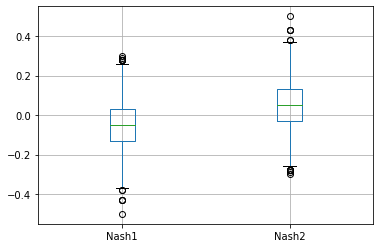

In [131]:
print("Nash equilibrium winnng rates: {:+.4f}".format(1/18))
print("Simulated winning rates      : {:+.4f}, {:+.4f}".format(
    df_avgWinStats["Nash1"].mean(), df_avgWinStats["Nash2"].mean()))

df_avgWinStats.boxplot()

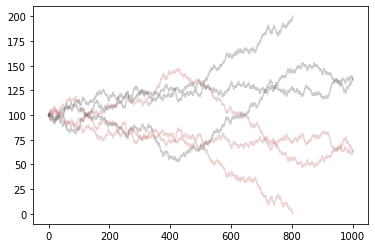

In [106]:
dict_colors = {
    "Random1": "red", 
    "Random2": "darkmagenta",
    "Deterministic1": "steelblue",
    "Deterministic2": "green",
    "Nash1": "brown",
    "Nash2": "black"}
for df_bankroll in list_bankrolls:
    for p in df_bankroll.columns:
        plt.plot(df_bankroll[p], alpha=0.2, color=dict_colors[p])

In [106]:
len(list_bankrolls)

10

In [95]:
game.df_PnL["Deterministic1"].mean(), game.df_PnL["Deterministic1"].std()

(0.19801980198019803, 1.4407601194610176)